Importando as bibliotecas, os vetorizadores, o stopwords, a regressão lógica, os classificadores, os medidores de precisão e as bibliotecas de visualização

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

import xgboost as xgb
from xgboost import XGBClassifier

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importando o CSV

In [ ]:
news_df = pd.read_csv('/content/csvFinal.csv')

In [ ]:
news_df['sobre'][0]

'O XV Congresso de Educação Física e Ciência do Desporto dos Países de Língua Portuguesa é um evento internacional de âmbito científico e acadêmico. Esta edição tem como Tema: O Desporto e a bola do mundo: Sociedade, Inovação e Tecnologia.'

Verificando as informações do CSV

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   categoria  78 non-null     object
 1   sobre      77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


Contando quantos tem por categoria

In [ ]:
news_df['categoria'].value_counts()

Educação                                 29
Negócios e Administração                 11
Artes e Humanidade                        6
Saúde e Bem-Estar                         5
Desenvolvimento Pessoal                   4
Medicina                                  4
Engenharias                               4
Gastronomia                               3
Religioso e Espiritualidade               3
Computação e Tecnologia da Informação     3
Empreendedorismo e Inovação               3
Ciências Sociais e Jornalismo             2
Direito                                   1
Name: categoria, dtype: int64

In [ ]:
news_df['categoria_id'] = news_df['categoria'].factorize()[0]

Part 2. Vizualização

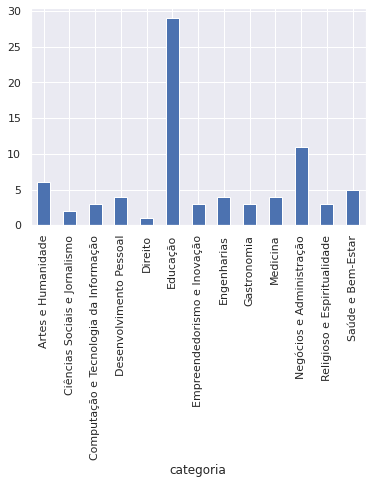

In [ ]:
#Distribuição de artigos de notícias por categoria
news_df.groupby('categoria').categoria_id.count().plot.bar()

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   categoria     78 non-null     object
 1   sobre         77 non-null     object
 2   categoria_id  78 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ KB


In [ ]:
# Crie um novo dataframe "categoria_id_df", que tem apenas categorias exclusivas, também classificando esta lista na ordem dos valores de categoria_id
categoria_id_df = news_df[['categoria', 'categoria_id']].drop_duplicates().sort_values('categoria_id')

# Crie um dicionário (estrutura de dados python - como uma tabela de pesquisa) que 
# pode facilmente converter nomes de categorias em categoria_ids e vice-versa
categoria_to_id = dict(categoria_id_df.values)
id_to_categoria = dict(categoria_id_df[['categoria_id', 'categoria']].values)

categoria_to_id
#categoria_to_id['tech']

{'Artes e Humanidade': 2,
 'Ciências Sociais e Jornalismo': 8,
 'Computação e Tecnologia da Informação': 12,
 'Desenvolvimento Pessoal': 9,
 'Direito': 10,
 'Educação': 0,
 'Empreendedorismo e Inovação': 4,
 'Engenharias': 11,
 'Gastronomia': 7,
 'Medicina': 1,
 'Negócios e Administração': 3,
 'Religioso e Espiritualidade': 5,
 'Saúde e Bem-Estar': 6}

In [ ]:
# Eliminar dados duplicados
news_df.drop_duplicates(keep="first", inplace=True)

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   categoria     78 non-null     object
 1   sobre         77 non-null     object
 2   categoria_id  78 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


In [ ]:
# Limpeza de Dados
def clean_text(sobre):
    # remova tudo exceto alfabetos
    text = re.sub(r'[-./?!,":;()><\'1234567890]', " ", str(sobre))
    # remover espaços em branco
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [ ]:
# criando uma coluna com texto limpo
news_df['clean_sobre'] = news_df['sobre'].apply(clean_text)

In [ ]:
news_df.sobre[0]

'O XV Congresso de Educação Física e Ciência do Desporto dos Países de Língua Portuguesa é um evento internacional de âmbito científico e acadêmico. Esta edição tem como Tema: O Desporto e a bola do mundo: Sociedade, Inovação e Tecnologia.'

In [ ]:
news_df.clean_sobre[0]

'o xv congresso de educação física e ciência do desporto dos países de língua portuguesa é um evento internacional de âmbito científico e acadêmico esta edição tem como tema o desporto e a bola do mundo sociedade inovação e tecnologia'

In [ ]:
news_df.head()

,categoria,sobre,categoria_id,clean_sobre
0,Educação,O XV Congresso de Educação Física e Ciência do...,0,o xv congresso de educação física e ciência do...
1,Educação,A Associação Brasileira de Biologia Marinha te...,0,a associação brasileira de biologia marinha te...
2,Medicina,A Jornada Acadêmica de Farmácia é um evento de...,1,a jornada acadêmica de farmácia é um evento de...
3,Artes e Humanidade,O XIV SEMPEM propõe discussões acerca das açõe...,2,o xiv sempem propõe discussões acerca das açõe...
4,Negócios e Administração,"Este é um evento de capacitação profissional, ...",3,este é um evento de capacitação profissional c...


Quais são as palavras mais frequentes no nosso dataframe?

In [ ]:
#https://www.nltk.org/
all_words = ' '.join([text for text in news_df['clean_sobre']])
all_words = all_words.split()
freq_dist = nltk.FreqDist(all_words)
words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
words_df.head() 

,word,count
0,o,142
1,xv,3
2,congresso,13
3,de,590
4,educação,17


In [ ]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    #https://www.nltk.org/
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

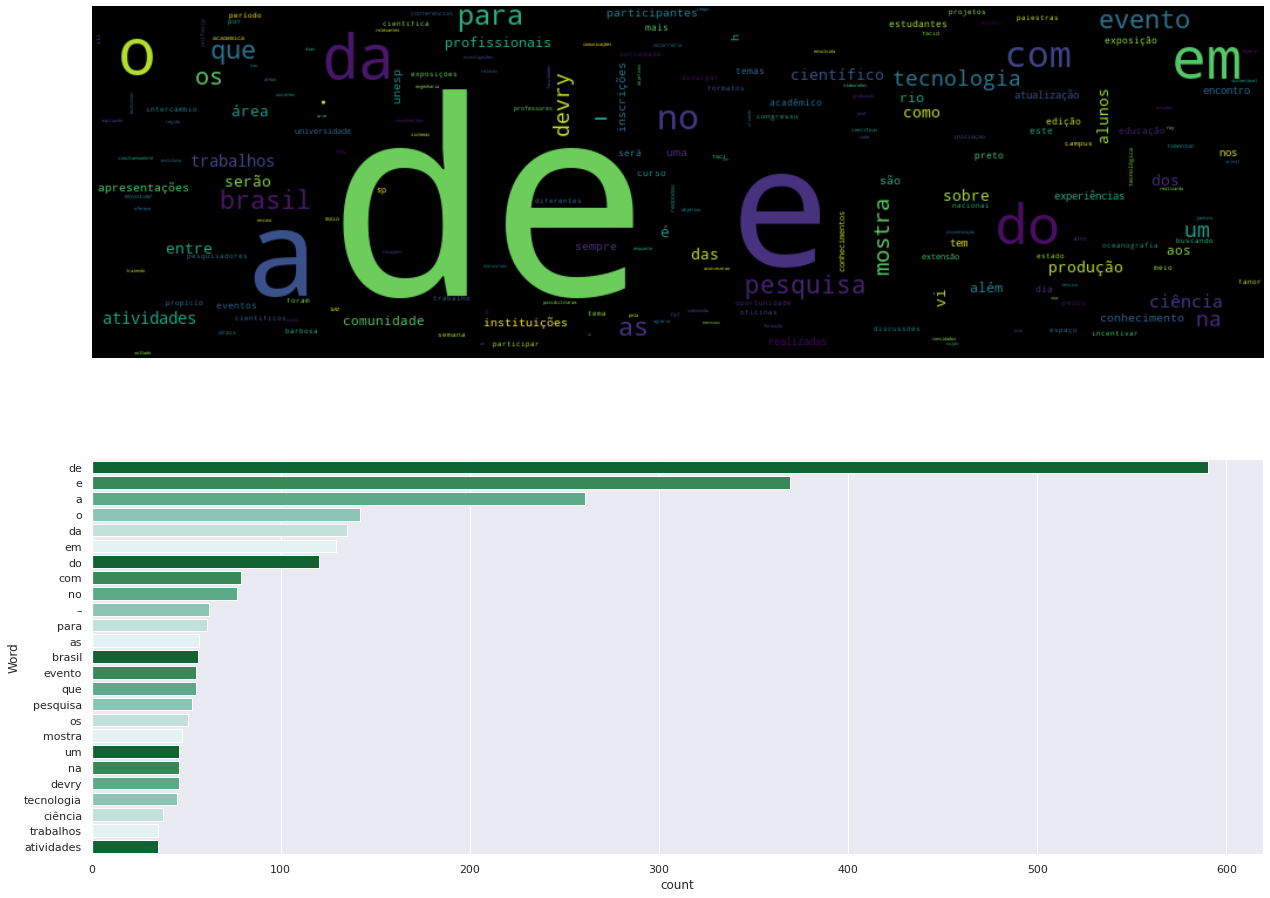

In [ ]:
# plot 25 most frequent words including stop words
freq_words(news_df['clean_sobre'], 25)

In [ ]:
#https://pypi.org/project/stop-words/
#stop_words = set(stopwords.words('portuguese')) 
#stop_words = set(stopwords.words('english'))
#stop_words

In [ ]:
stop_wordsPTBR = stopwords.words('portuguese')
words2 = ['congresso', 'congressos', 'evento', '\n', 'eventos', 'workshop', 'conferência', 'conferências', 'coffe', 'break', 'cupom', 'desconto', 'palestrante', 'palestrantes', 'doutor', 'doutores', 'xv', 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii','xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx', 'xxi', 'xxii', 'xxiii', 'xxiv', 'xxv', 'xxvi', 'xxvii', 'xxviii', 'xxix', 'xxx', 'concelho', 'concelhos', 'classe', 'classes', 'reuniao', 'reunioes', 'xxxi', 'xxxii', 'xxxiii', 'xxxiv', 'xxxv' ,'xxxvi', 'xxxvii' ,'xxxviii', 'xxxix', 'xl', 'xli', 'xlii', 'xliii', 'xliv', 'xlv' ,'xlvi', 'xlvii', 'xlviii', 'xliv', 'xlv', 'xlvi', 'xlvii', 'xlviii' ,'xlix', 'lx', 'lxi', 'lxii', 'lxiii', 'lxiv', 'lxvi', 'lxv', 'lxvi', 'lxvii', 'lxviii', 'lxix', 'primeiro', 'segundo', 'terceiro', 'quarto', 'quinto', 'sexto', 'setimo', 'oitavo', 'decimo', 'primeira', 'segunda', 'terceira', 'quarta', 'quinta', 'sexta', 'setima', 'oitava', 'nona', 'nono', 'encontro', 'encontros', 'academia', 'academicos', 'simposio', 'simposios', 'curso', 'cursos', 'corporativo', 'corporacao', 'corporacoes', 'lxx', 'lxxi', 'lxxii', 'lxxiii', 'lxxiv', 'lxv', 'lxxvi', 'lxxvii', 'lxxviii', 'lxxix', 'lxxx']
#stop_wordsPTBR

In [ ]:
stop_wordsPTBR.extend(words2)

In [ ]:
# stopwords-to compare text data with and without stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_wordsPTBR]
    return ' '.join(no_stopword_text)
  
news_df['clean_sobre'] = news_df['clean_sobre'].apply(lambda x: remove_stopwords(x))

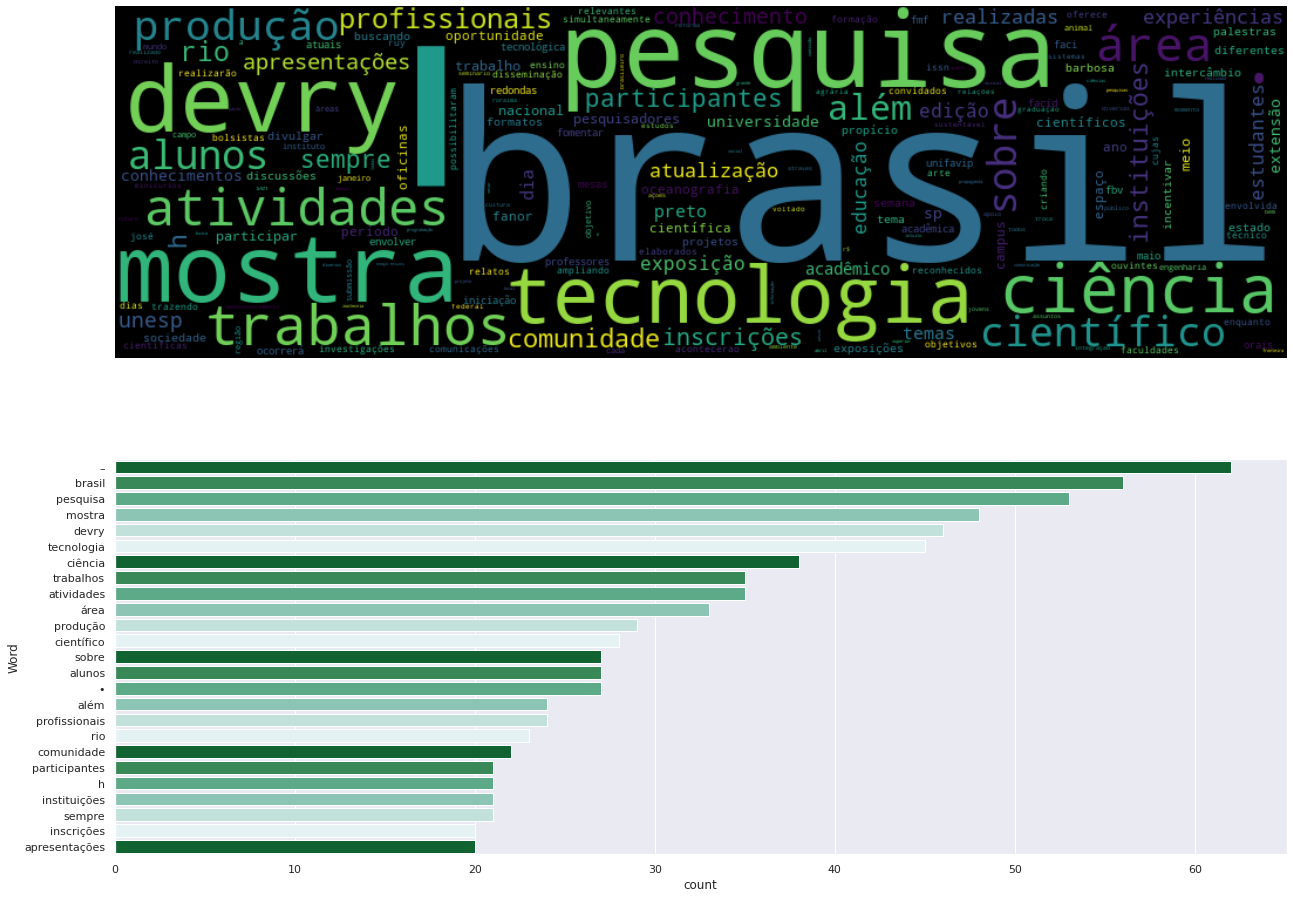

In [ ]:
# plot 25 most frequent words without stopwords
freq_words(news_df['clean_sobre'], 25)

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   categoria     78 non-null     object
 1   sobre         77 non-null     object
 2   categoria_id  78 non-null     int64 
 3   clean_sobre   78 non-null     object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


Part 3: Heading to Machine Learning

In [ ]:
# Processo de lematização
'''
Palavras na terceira pessoa são alteradas para primeira pessoa e os verbos no passado e no futuro são alterados para o presente pelo
processo de lematização.
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [ ]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
count_vec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)
tfidf_vec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize_and_lemmatize at 0x7f7299105320>,
                use_idf=True, vocabulary=None)

In [ ]:
features = tfidf_vec.fit_transform(news_df.clean_sobre).toarray() # Remaps the words in the 2225 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = news_df.categoria_id                           # represents the categoria of each of the 2225 articles

In [ ]:
labels

0      0
1      0
2      1
3      2
4      3
      ..
73    12
74     0
75    12
76     8
77     0
Name: categoria_id, Length: 78, dtype: int64

In [ ]:
#Get a feel of the features identified by tfidf
features.shape # How many features are there ? 

(78, 4458)

In [ ]:
# Remember the dictionary created to map categoria names to a number ? 
categoria_to_id.items()

dict_items([('Educação', 0), ('Medicina', 1), ('Artes e Humanidade', 2), ('Negócios e Administração', 3), ('Empreendedorismo e Inovação', 4), ('Religioso e Espiritualidade', 5), ('Saúde e Bem-Estar', 6), ('Gastronomia', 7), ('Ciências Sociais e Jornalismo', 8), ('Desenvolvimento Pessoal', 9), ('Direito', 10), ('Engenharias', 11), ('Computação e Tecnologia da Informação', 12)])

In [ ]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(categoria_to_id.items())

[('Artes e Humanidade', 2),
 ('Ciências Sociais e Jornalismo', 8),
 ('Computação e Tecnologia da Informação', 12),
 ('Desenvolvimento Pessoal', 9),
 ('Direito', 10),
 ('Educação', 0),
 ('Empreendedorismo e Inovação', 4),
 ('Engenharias', 11),
 ('Gastronomia', 7),
 ('Medicina', 1),
 ('Negócios e Administração', 3),
 ('Religioso e Espiritualidade', 5),
 ('Saúde e Bem-Estar', 6)]

In [ ]:
news_df

,categoria,sobre,categoria_id,clean_sobre
0,Educação,O XV Congresso de Educação Física e Ciência do...,0,educação física ciência desporto países língua...
1,Educação,A Associação Brasileira de Biologia Marinha te...,0,associação brasileira biologia marinha satisfa...
2,Medicina,A Jornada Acadêmica de Farmácia é um evento de...,1,jornada acadêmica farmácia importância tanto a...
3,Artes e Humanidade,O XIV SEMPEM propõe discussões acerca das açõe...,2,sempem propõe discussões acerca ações interaçõ...
4,Negócios e Administração,"Este é um evento de capacitação profissional, ...",3,capacitação profissional ênfase consolidação c...
...,...,...,...,...
73,Computação e Tecnologia da Informação,I Semana da Informática - IFGoiano - Morrinhos,12,semana informática ifgoiano morrinhos
74,Educação,"Lightning Talk - TI Fanor. A Fanor/Devry, visa...",0,lightning talk ti fanor fanor devry visando pr...
75,Computação e Tecnologia da Informação,Tech Week Nabuco,12,tech week nabuco
76,Ciências Sociais e Jornalismo,III Congresso Ibero-americano sobre Assédio Mo...,8,ibero americano sobre assédio moral trabalho g...


In [ ]:
news_df.to_csv('out_df.csv', index=False)
news_df

,categoria,sobre,categoria_id,clean_sobre
0,Educação,O XV Congresso de Educação Física e Ciência do...,0,educação física ciência desporto países língua...
1,Educação,A Associação Brasileira de Biologia Marinha te...,0,associação brasileira biologia marinha satisfa...
2,Medicina,A Jornada Acadêmica de Farmácia é um evento de...,1,jornada acadêmica farmácia importância tanto a...
3,Artes e Humanidade,O XIV SEMPEM propõe discussões acerca das açõe...,2,sempem propõe discussões acerca ações interaçõ...
4,Negócios e Administração,"Este é um evento de capacitação profissional, ...",3,capacitação profissional ênfase consolidação c...
...,...,...,...,...
73,Computação e Tecnologia da Informação,I Semana da Informática - IFGoiano - Morrinhos,12,semana informática ifgoiano morrinhos
74,Educação,"Lightning Talk - TI Fanor. A Fanor/Devry, visa...",0,lightning talk ti fanor fanor devry visando pr...
75,Computação e Tecnologia da Informação,Tech Week Nabuco,12,tech week nabuco
76,Ciências Sociais e Jornalismo,III Congresso Ibero-americano sobre Assédio Mo...,8,ibero americano sobre assédio moral trabalho g...


In [ ]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news categoria) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each categoria, find words that are highly corelated to it
for categoria, categoria_id in sorted(categoria_to_id.items()):
    features_chi2 = chi2(features, labels == categoria_id)                   # Do chi2 analyses of all items in this categoria
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(categoria))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

In [ ]:
features_chi2

(array([0.01611268, 0.01611268, 0.0025534 , ..., 0.00130611, 0.00457309,
        0.00457309]),
 array([0.89899128, 0.89899128, 0.9596991 , ..., 0.97117059, 0.94608445,
        0.94608445]))

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   categoria     78 non-null     object
 1   sobre         77 non-null     object
 2   categoria_id  78 non-null     int64 
 3   clean_sobre   78 non-null     object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


In [ ]:
X = news_df.loc[:,'clean_sobre']
y = news_df.loc[:,'categoria_id']

In [ ]:
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, news_df.index, test_size=0.2)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.25, random_state=10)

In [ ]:
# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
#xcv_tfidf = tfidf_vec.fit_transform(X_cv)
xtrain_tfidf.shape

(62, 4075)

In [ ]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)
xtrain_cv.shape

(62, 1491)

Part 4: Model Training and Evaluation

In [ ]:
#create list of model and accuracy dicts
perform_list = []

In [ ]:
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)        

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [ ]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 31.25
Precision : 0.3125
Recall    : 0.3125
F1-score   : 0.3125


In [ ]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 31.25
Precision : 0.3125
Recall    : 0.3125
F1-score   : 0.3125


In [ ]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 31.25
Precision : 0.3125
Recall    : 0.3125
F1-score   : 0.3125


In [ ]:
run_model('Linear SVC', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Linear SVC: % 31.25
Precision : 0.3125
Recall    : 0.3125
F1-score   : 0.3125


Performance metrics of models

In [ ]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,31.25,0.31,0.31,0.31
1,Logistic Regression,31.25,0.31,0.31,0.31
2,Multinomial Naive Bayes,31.25,0.31,0.31,0.31
3,Linear SVC,31.25,0.31,0.31,0.31


In [ ]:
from sklearn.naive_bayes import MultinomialNB
modelo = MultinomialNB()
modelo.fit(vetores_de_texto, classificacao)